In [2]:
import graph_tool.all as gt
import pandas as pd
import scipy.spatial
import scipy.cluster
import pandas as pd
import seaborn as sns
import sklearn.metrics
import pickle
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [40]:
dataset = ['10XV3_075',  'iCELL8_075' , 'Quartzseq_075', 
           'MARSseq_075', 'Crypt_C05', 'Planaria_schist']
pc = [5, 10, 15, 20, 25, 30]
nn = [10, 15, 20, 25, 30, 35, 40]

In [41]:
n_levels = 5

In [42]:
sdf1 = []
D = []
P = []
N = []
L = []
C = []
V = []
E = []
M = []
for d in dataset:
    for p in pc:
        for n in nn:
            state = pickle.load(open(f'States/{d}_p{p}_n{n}.pkl', 'rb'))
            g = state.g
            n_levels = min(len(state.get_bs()), 5)
            for l in range(n_levels):
                bs = np.array(state.project_partition(l, 0).a)
                gr, counts = np.unique(bs, return_counts=True)
                n_c = len(counts)
                D = D + ([d.split('_')[0]] * n_c)
                P = P + ([p] * n_c)
                N = N + ([n] * n_c)
                L = L + ([l] * n_c)
                C = C + list(counts)
                M = M + ([n_c] * n_c)
                E = E + ([g.num_edges()] * n_c )
                V = V + ([g.num_vertices()] * n_c )



sdf1 = pd.DataFrame([D, P, N, L, C, M, E, V], index=['dataset', 'n_pcs', 'n_neighbors', 'level', 'size', 'n_communities', 'edges', 'vertices']).T
             

/Users/cittaro.davide/anaconda3/envs/experimental/lib/python3.8/site-packages/graph_tool/inference/blockmodel.py:387: UserWarning: unrecognized keyword arguments: ['sampling']
  warnings.warn("unrecognized keyword arguments: " +


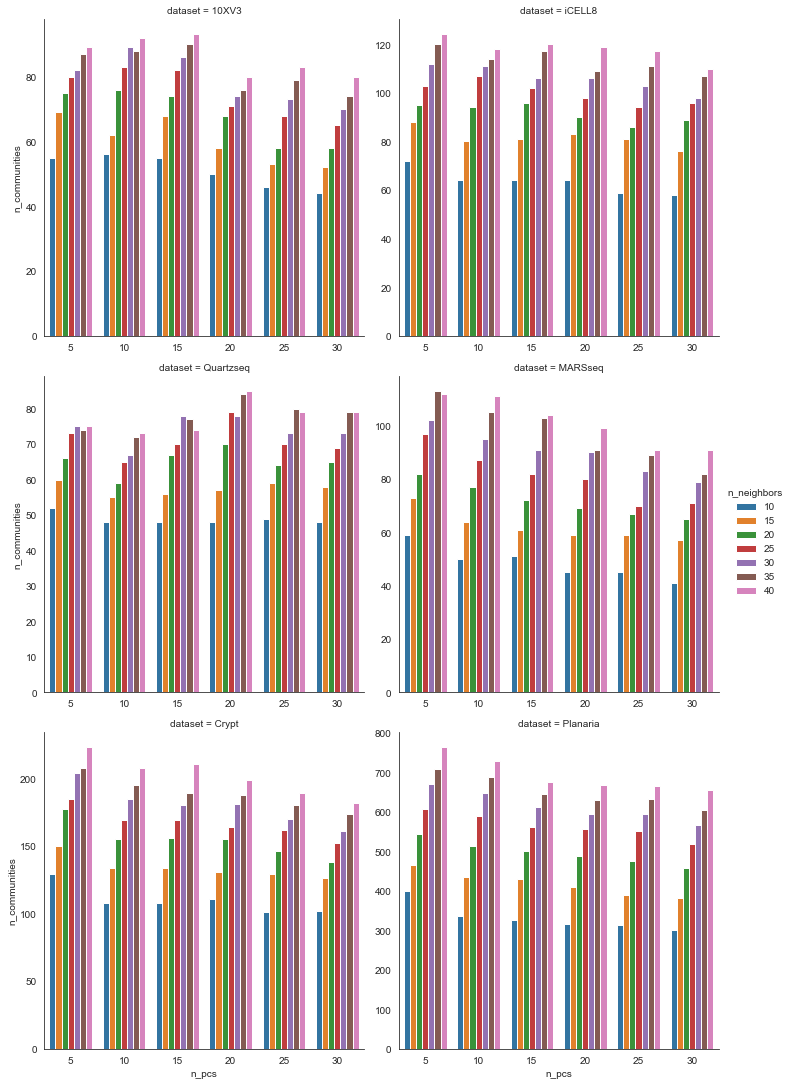

In [50]:
sns.set_style('white')
sns.catplot(data = sdf1.query('level == 0'), x='n_pcs',
            y='n_communities', hue='n_neighbors', 
            col='dataset', kind='bar', 
            col_wrap=2,sharex=False, sharey=False,)
savefig("Community_Count_L0.pdf", dpi=300)

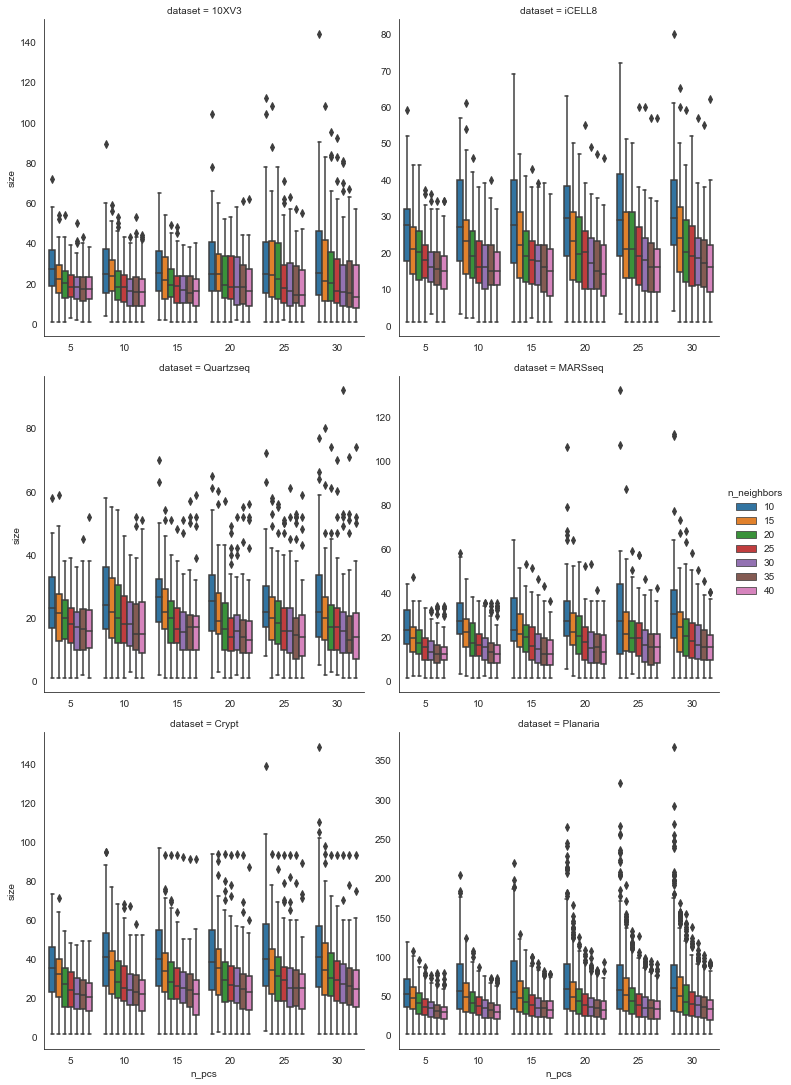

In [49]:
sns.set_style('white')
sns.catplot(data = sdf1.query('level == 0'), x='n_pcs',
            y='size', hue='n_neighbors', 
            col='dataset', kind='box', 
            col_wrap=2,sharex=False, sharey=False,)
savefig("Community_Size_L0.pdf", dpi=300)

/Users/cittaro.davide/anaconda3/envs/experimental/lib/python3.8/site-packages/graph_tool/inference/blockmodel.py:387: UserWarning: unrecognized keyword arguments: ['sampling']
  warnings.warn("unrecognized keyword arguments: " +
/Users/cittaro.davide/anaconda3/envs/experimental/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/cittaro.davide/anaconda3/envs/experimental/lib/python3.8/site-packages/graph_tool/inference/blockmodel.py:387: UserWarning: unrecognized keyword arguments: ['sampling']
  warnings.warn("unrecognized keyword arguments: " +
/Users/cittaro.davide/anaconda3/envs/experimental/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed dista

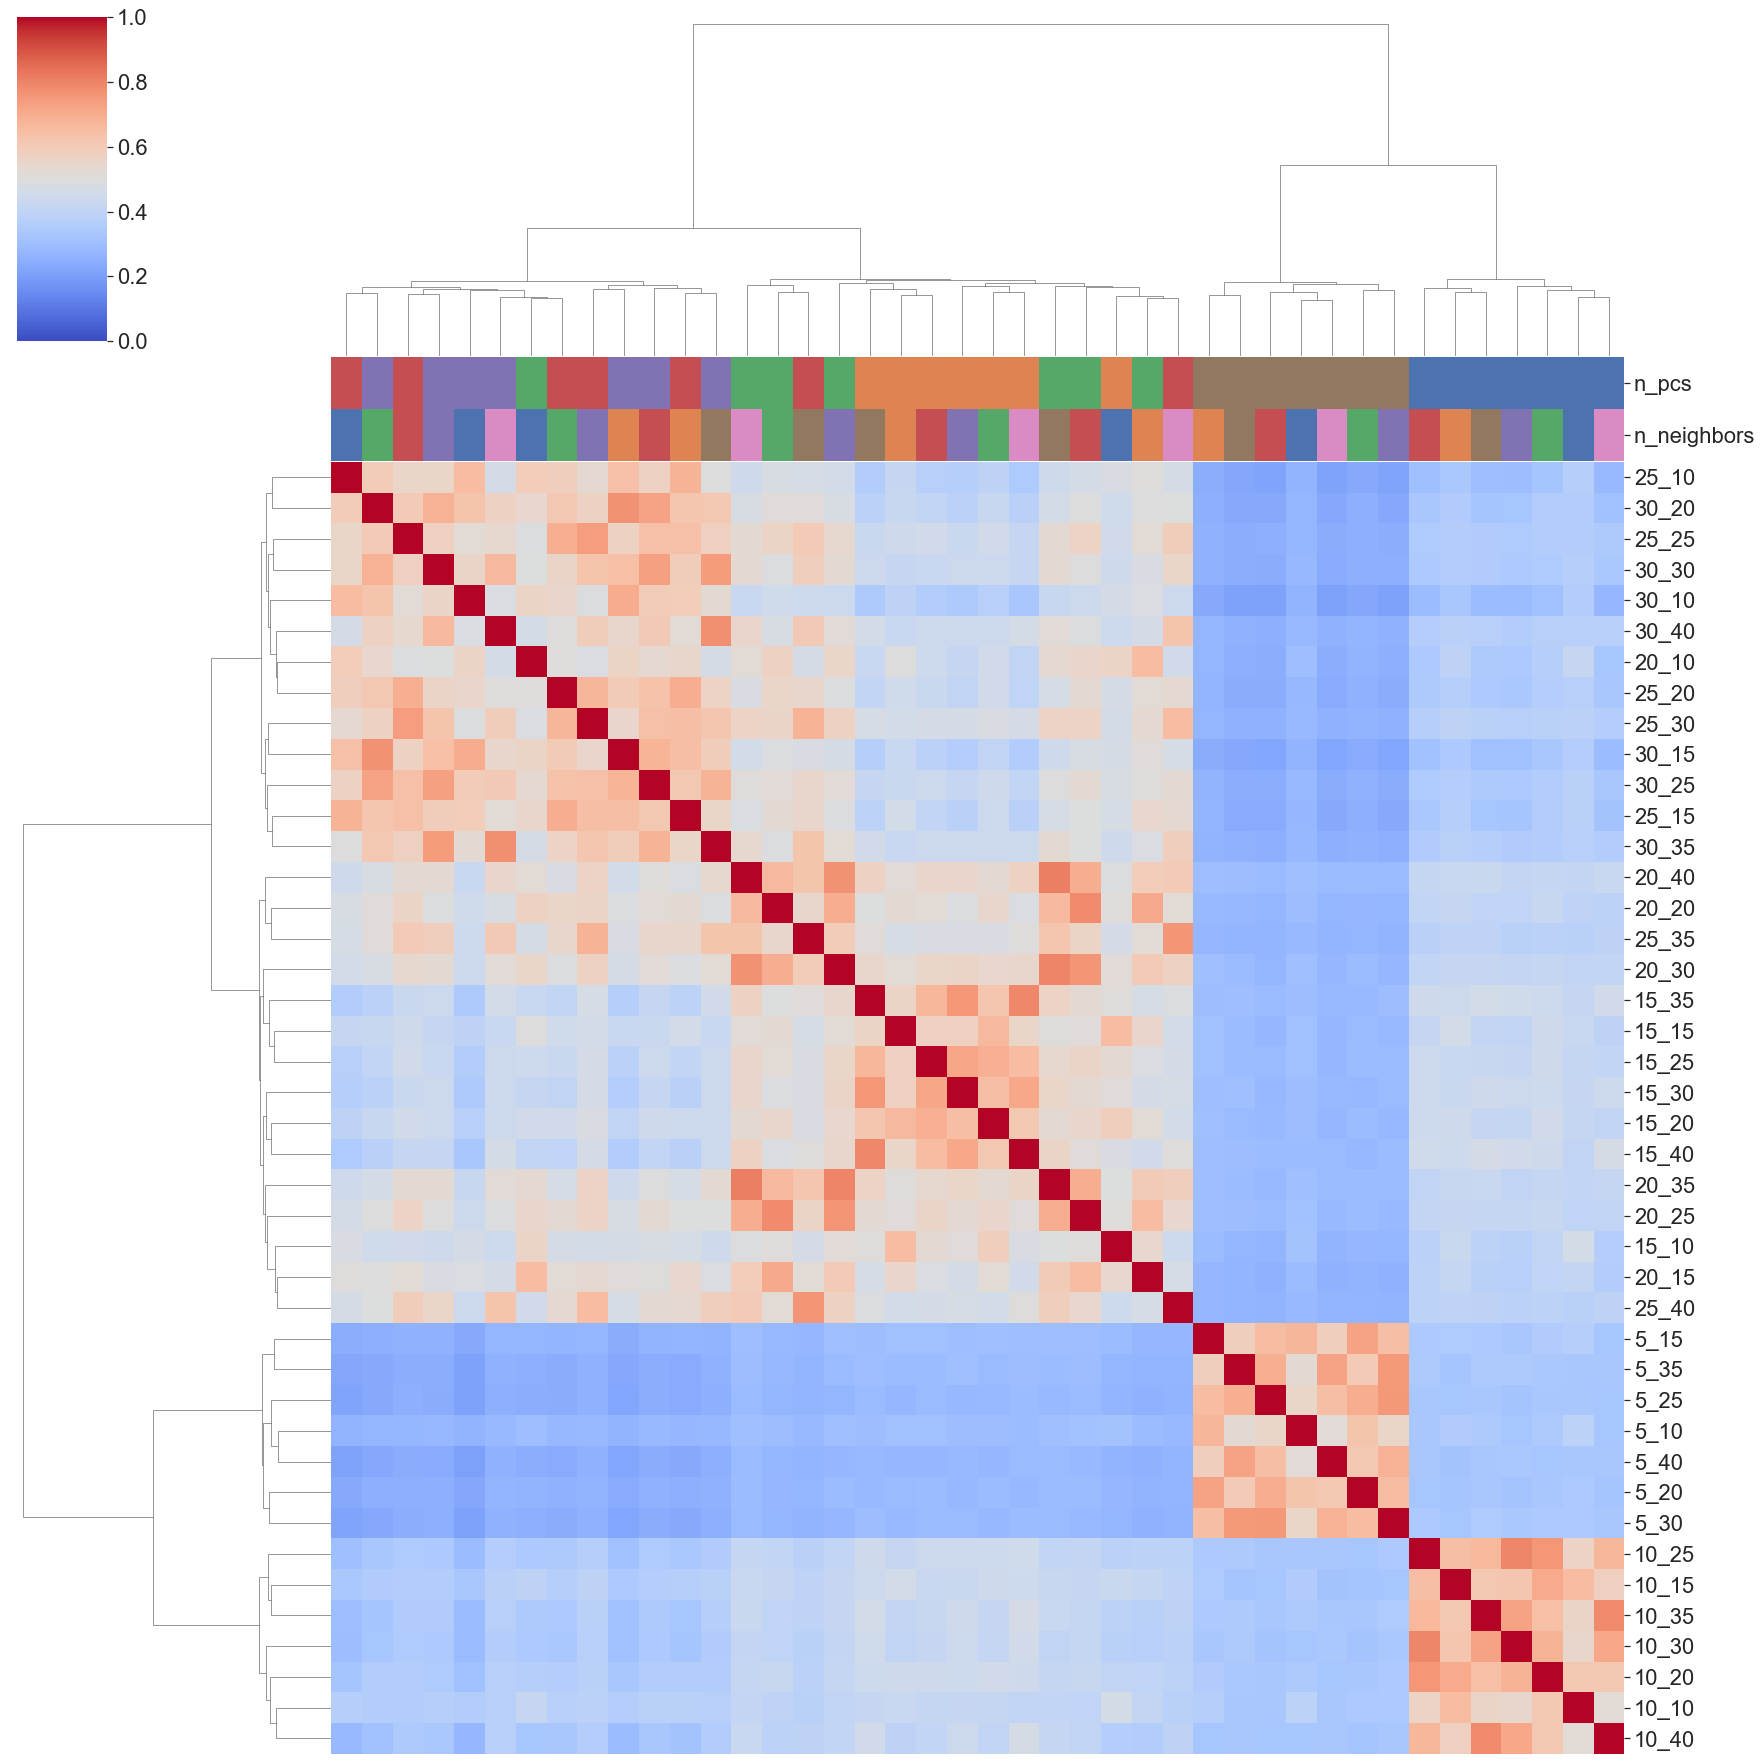

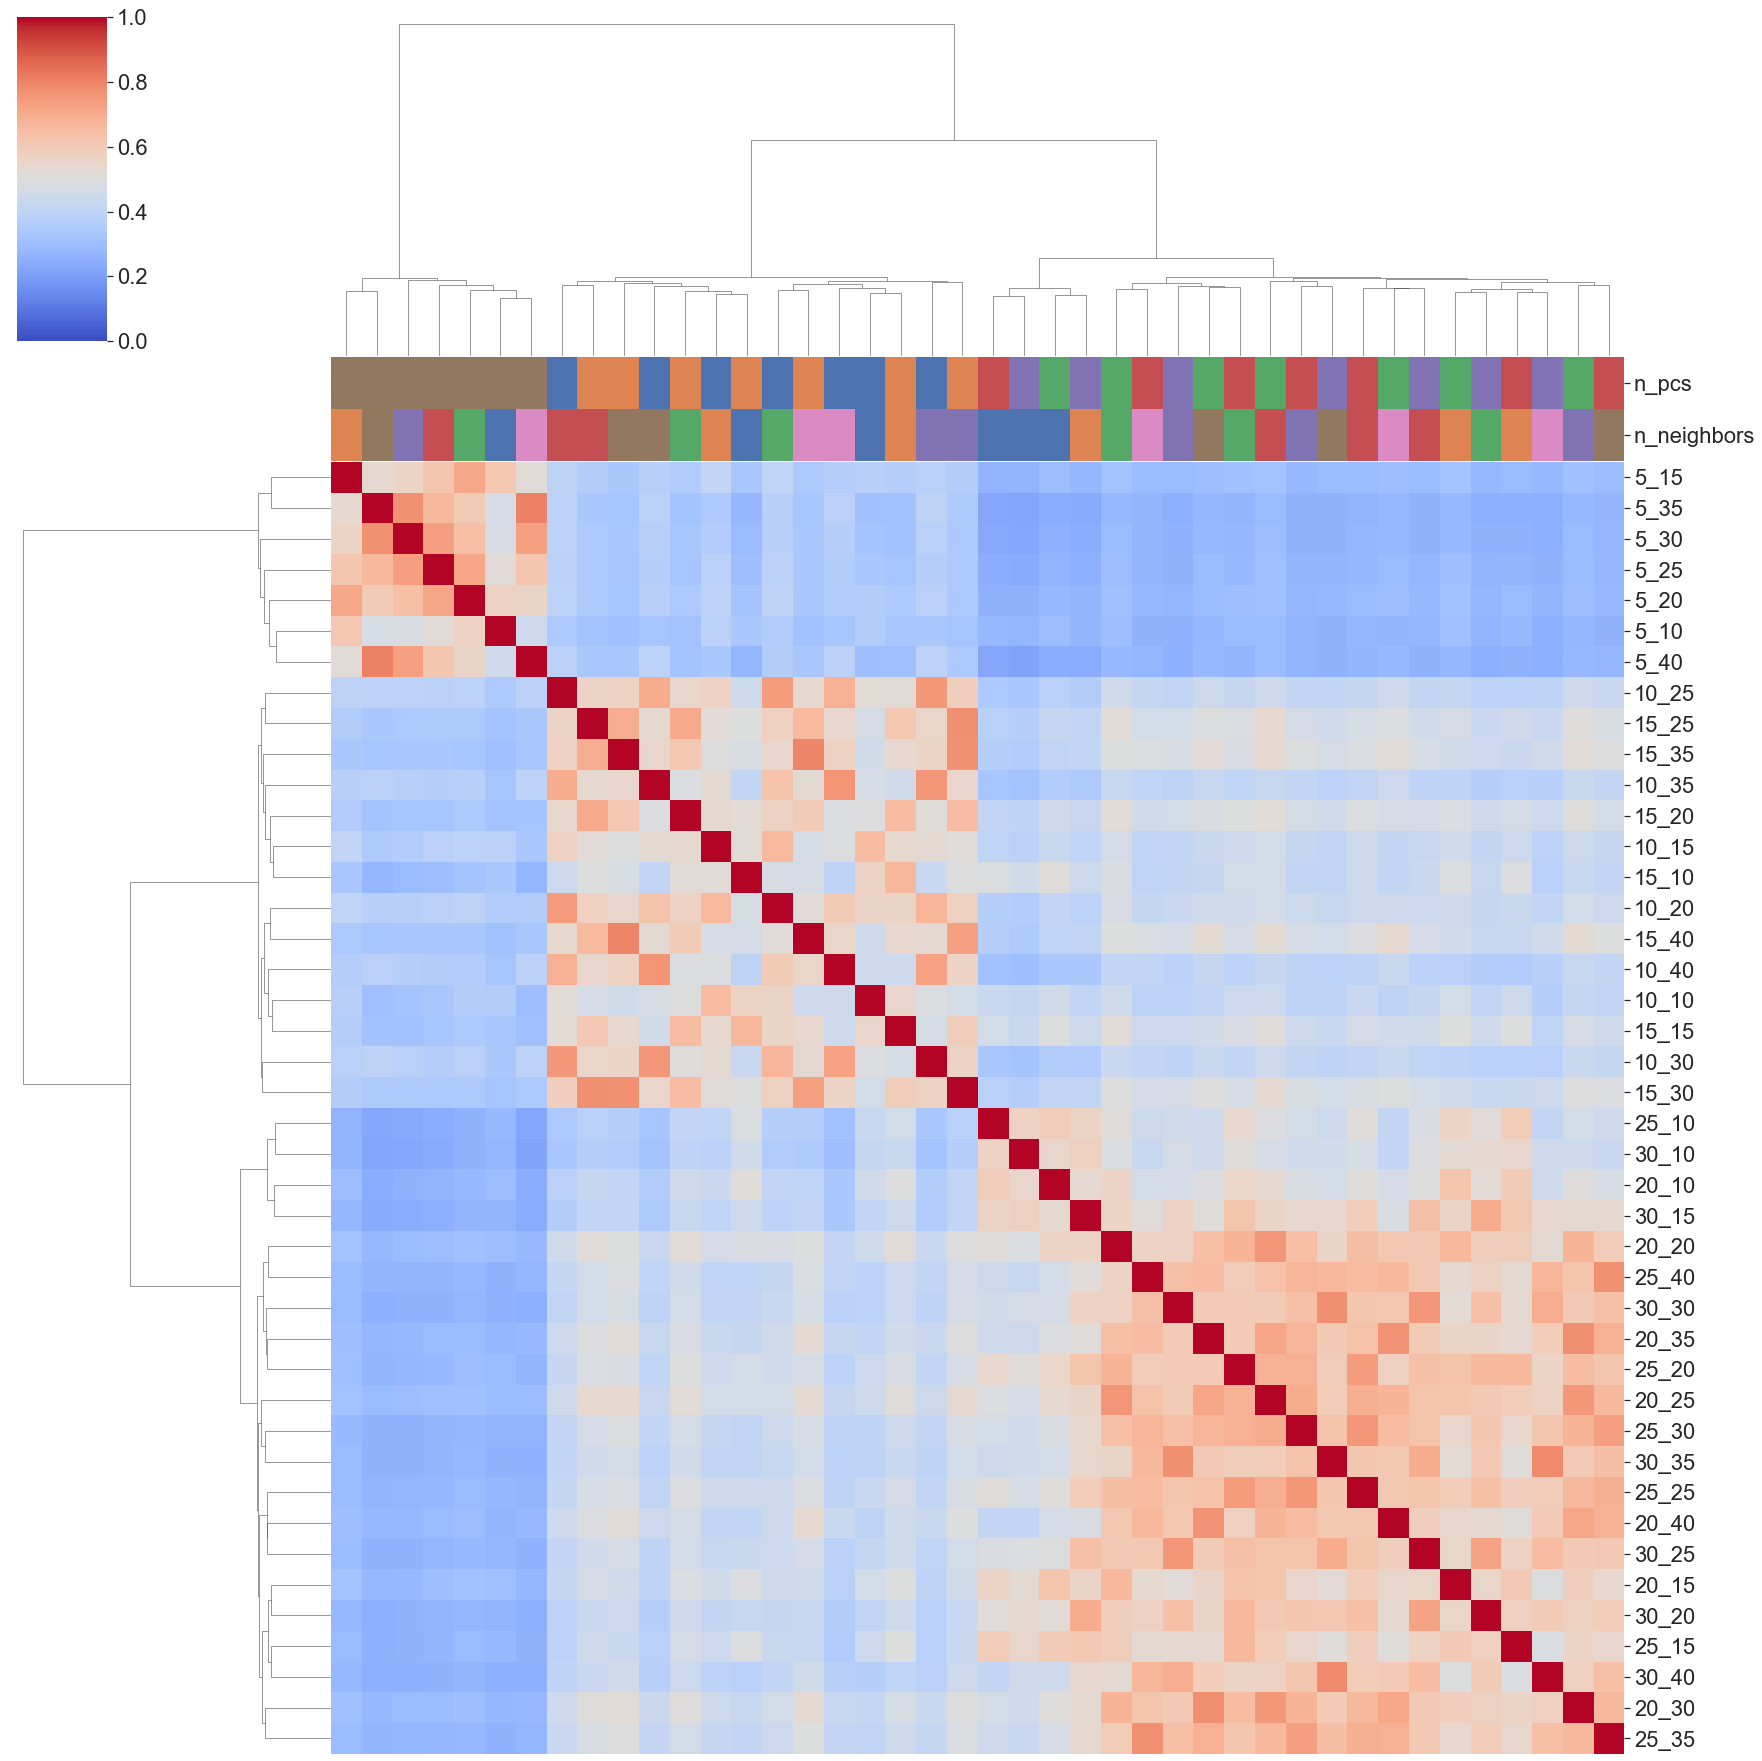

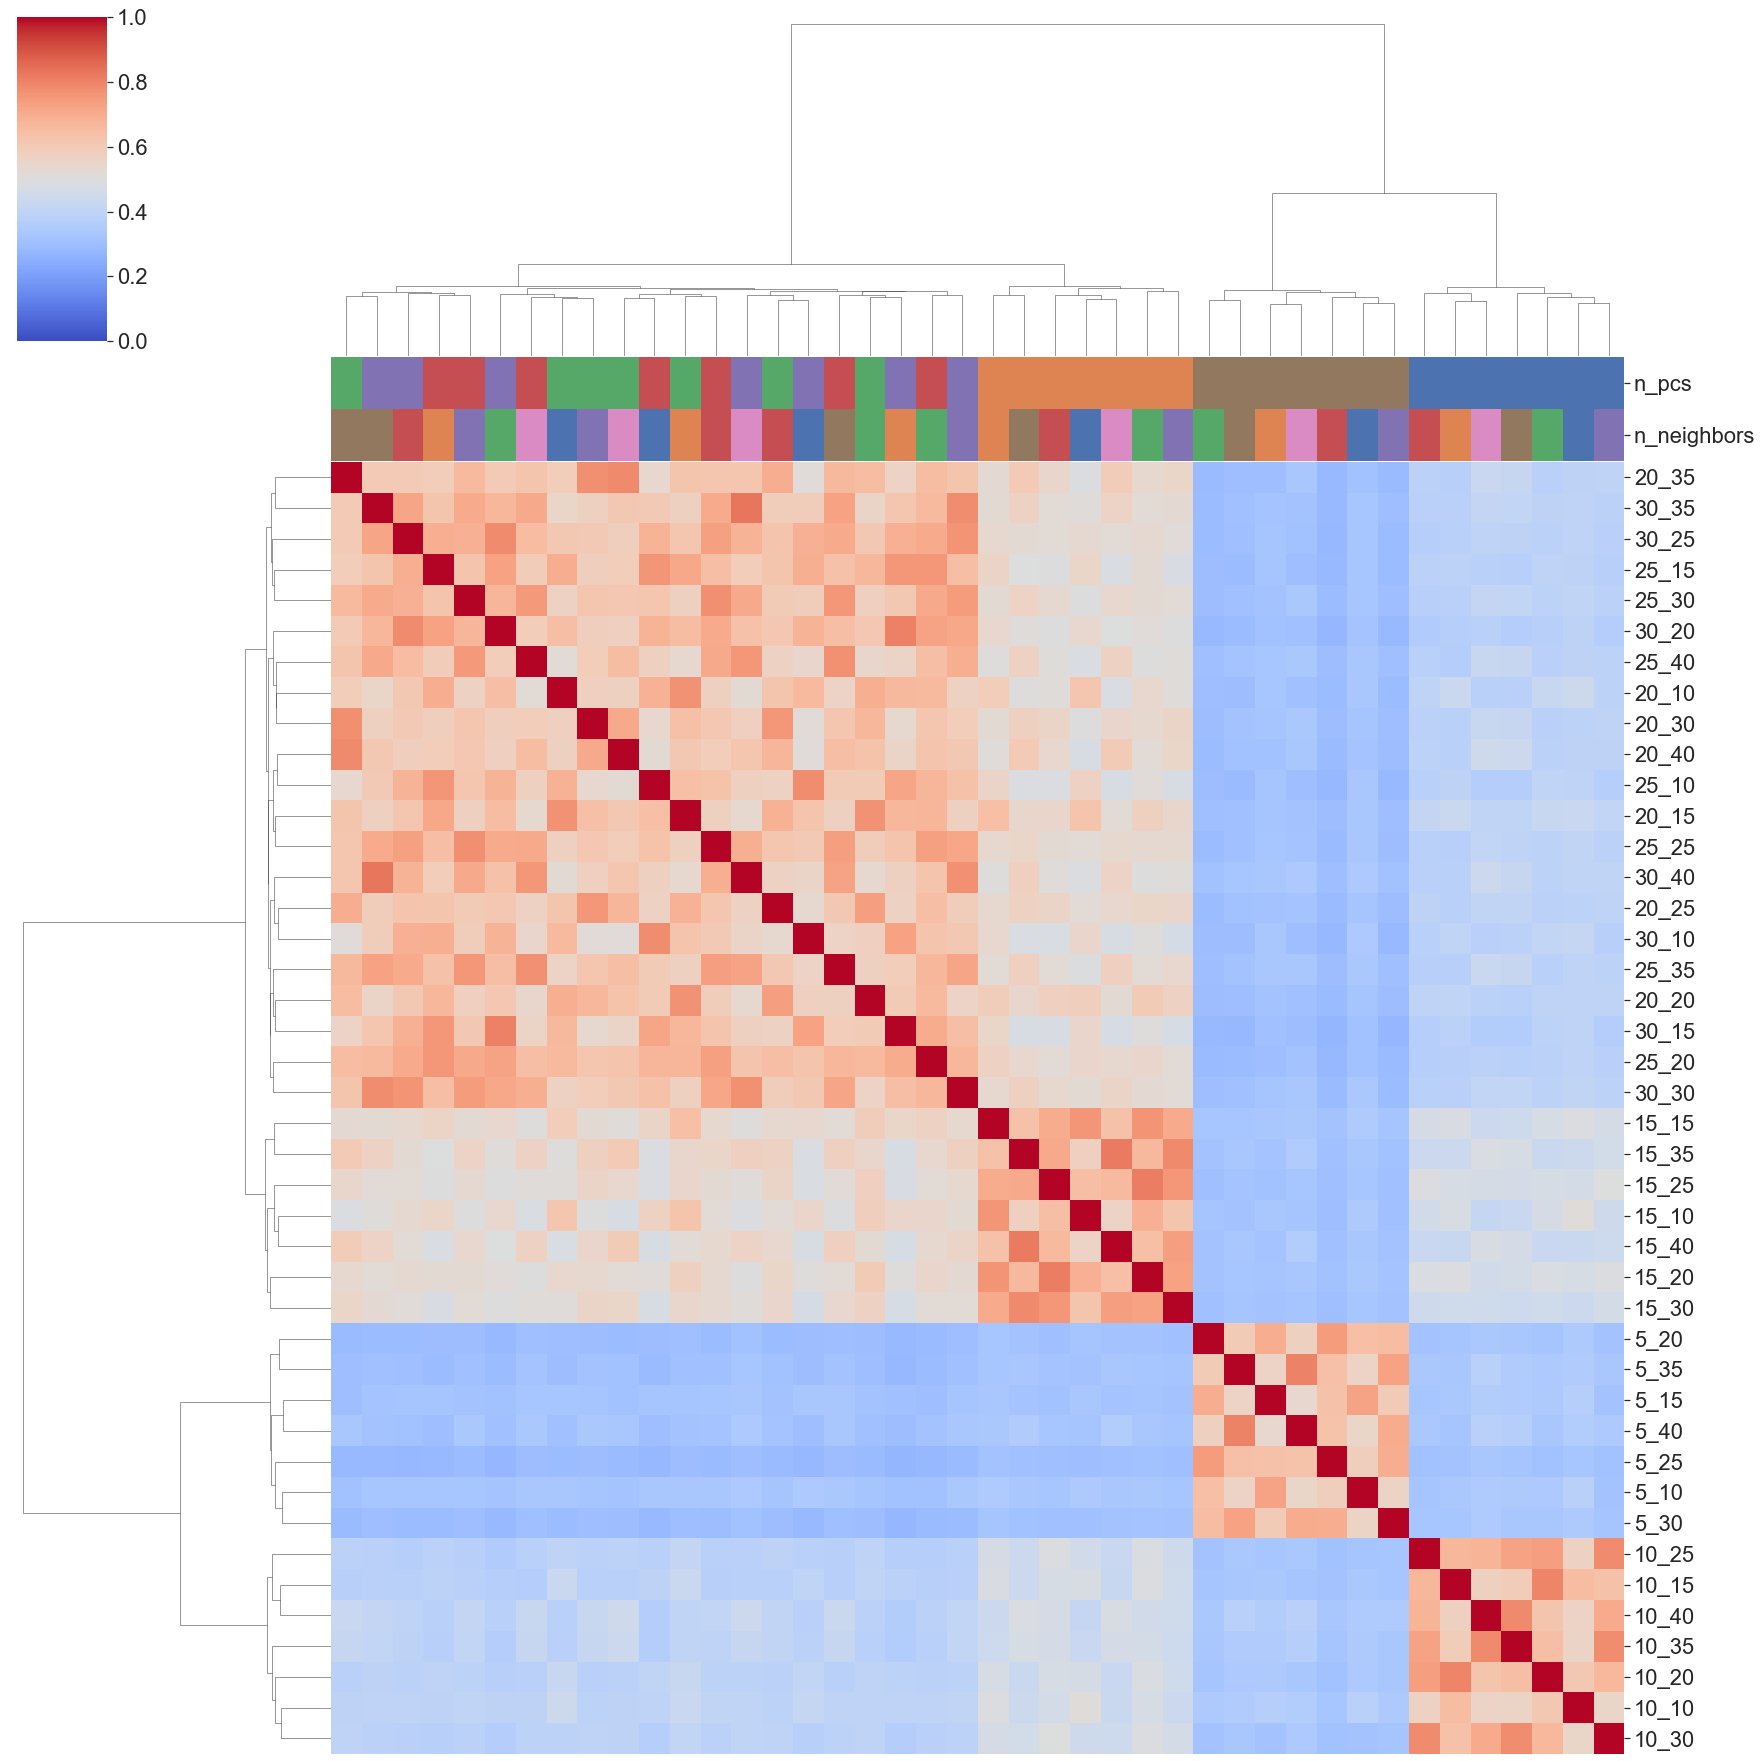

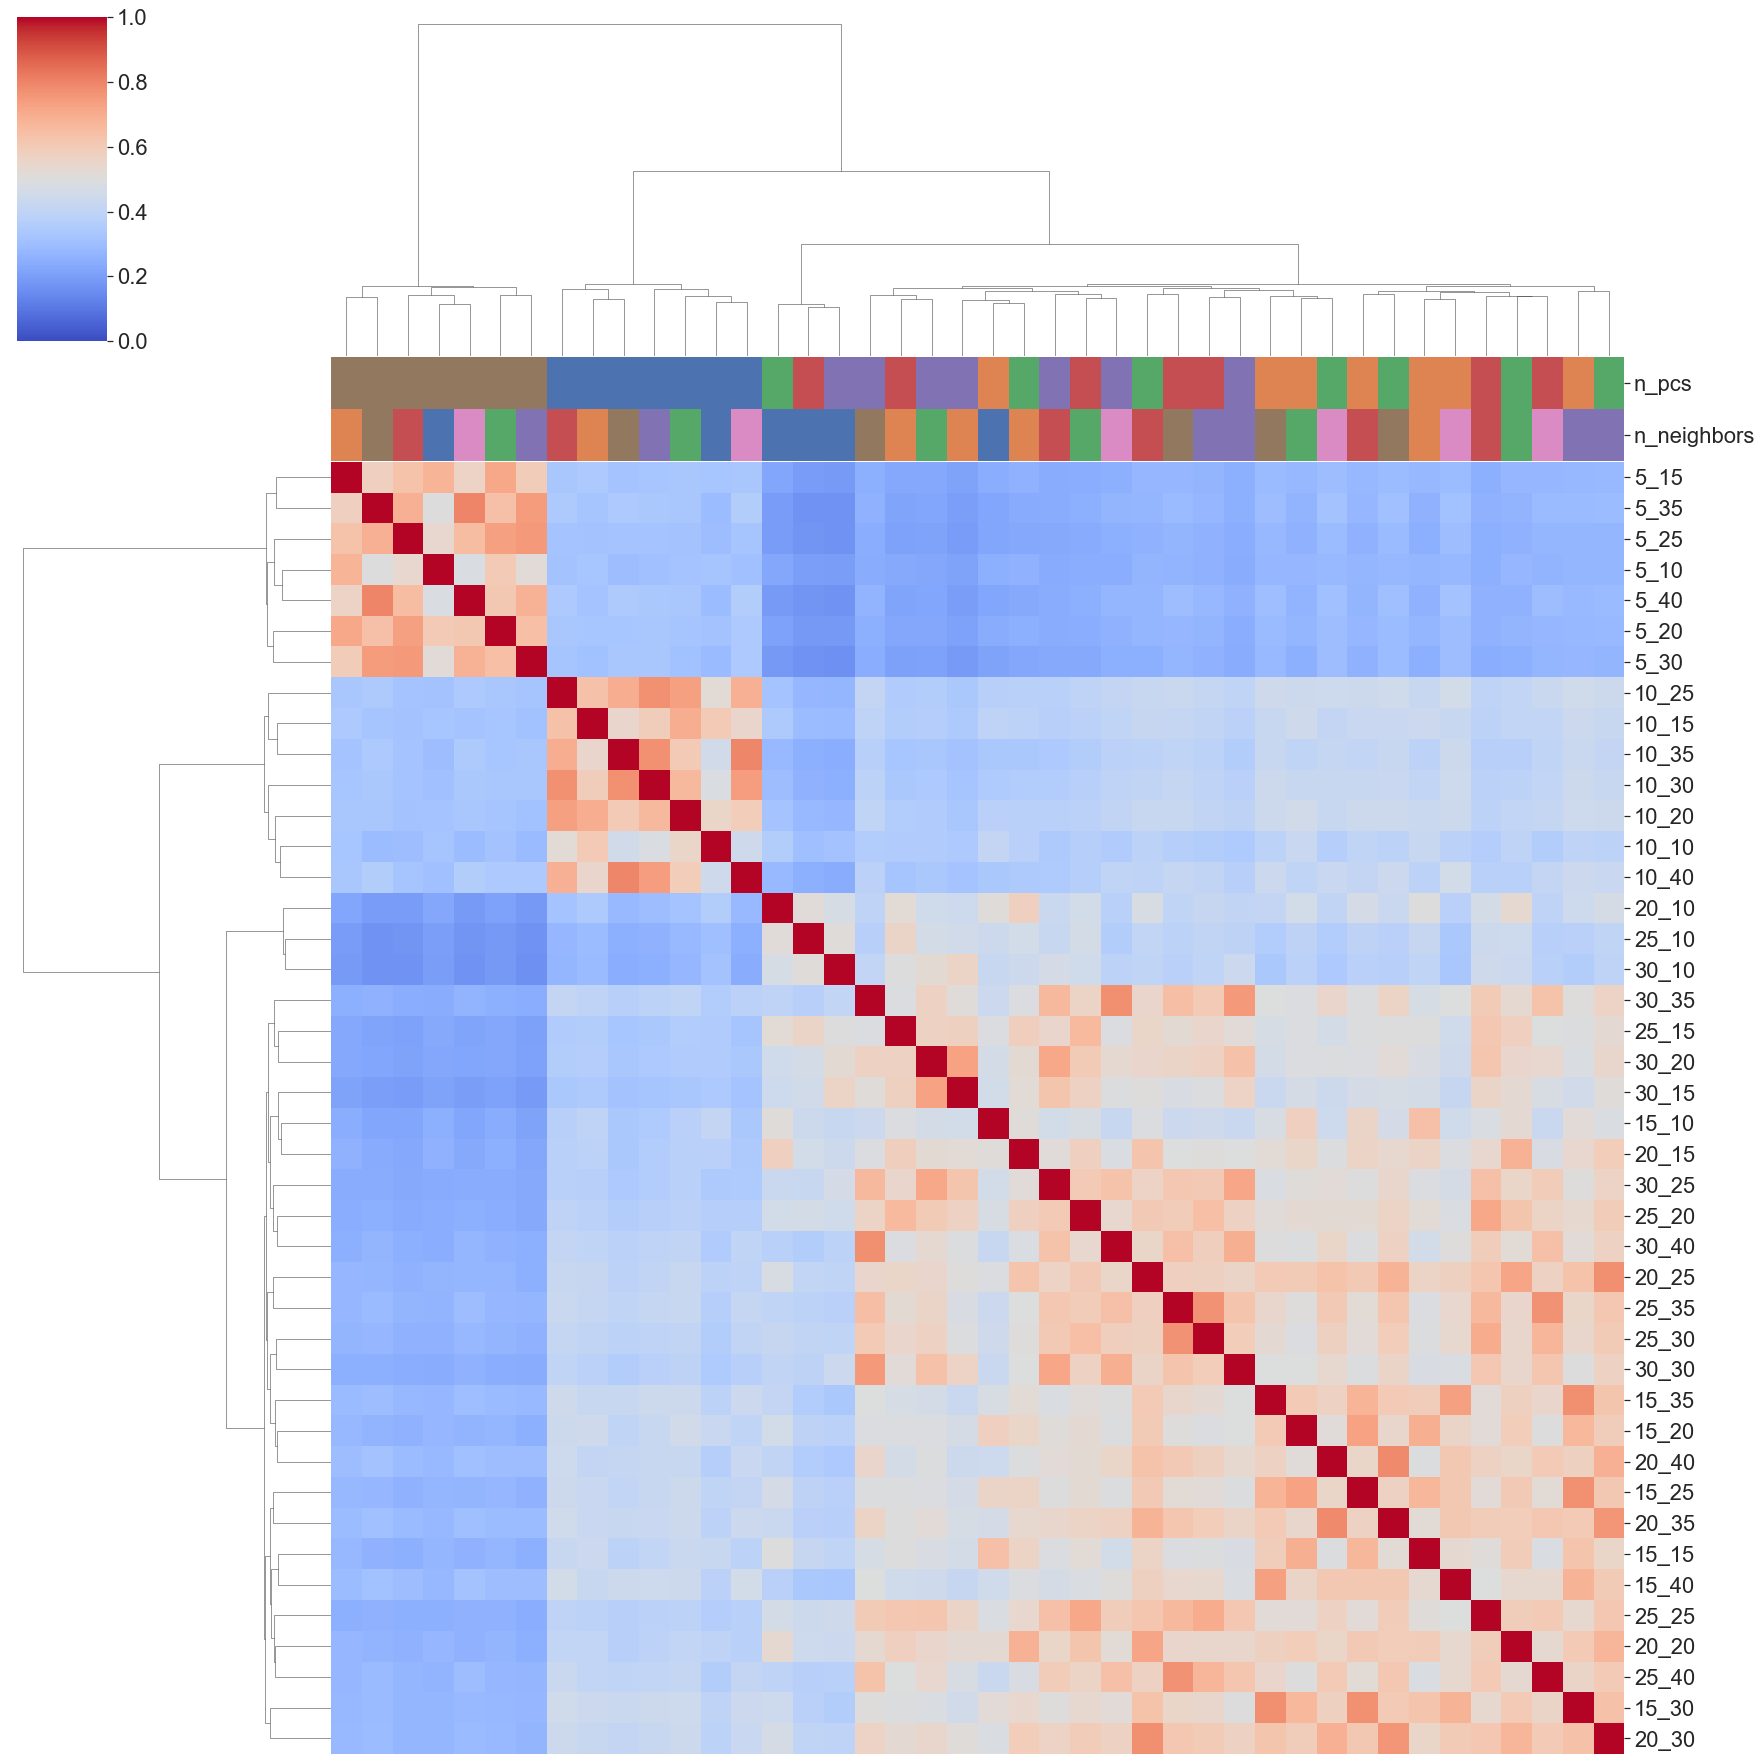

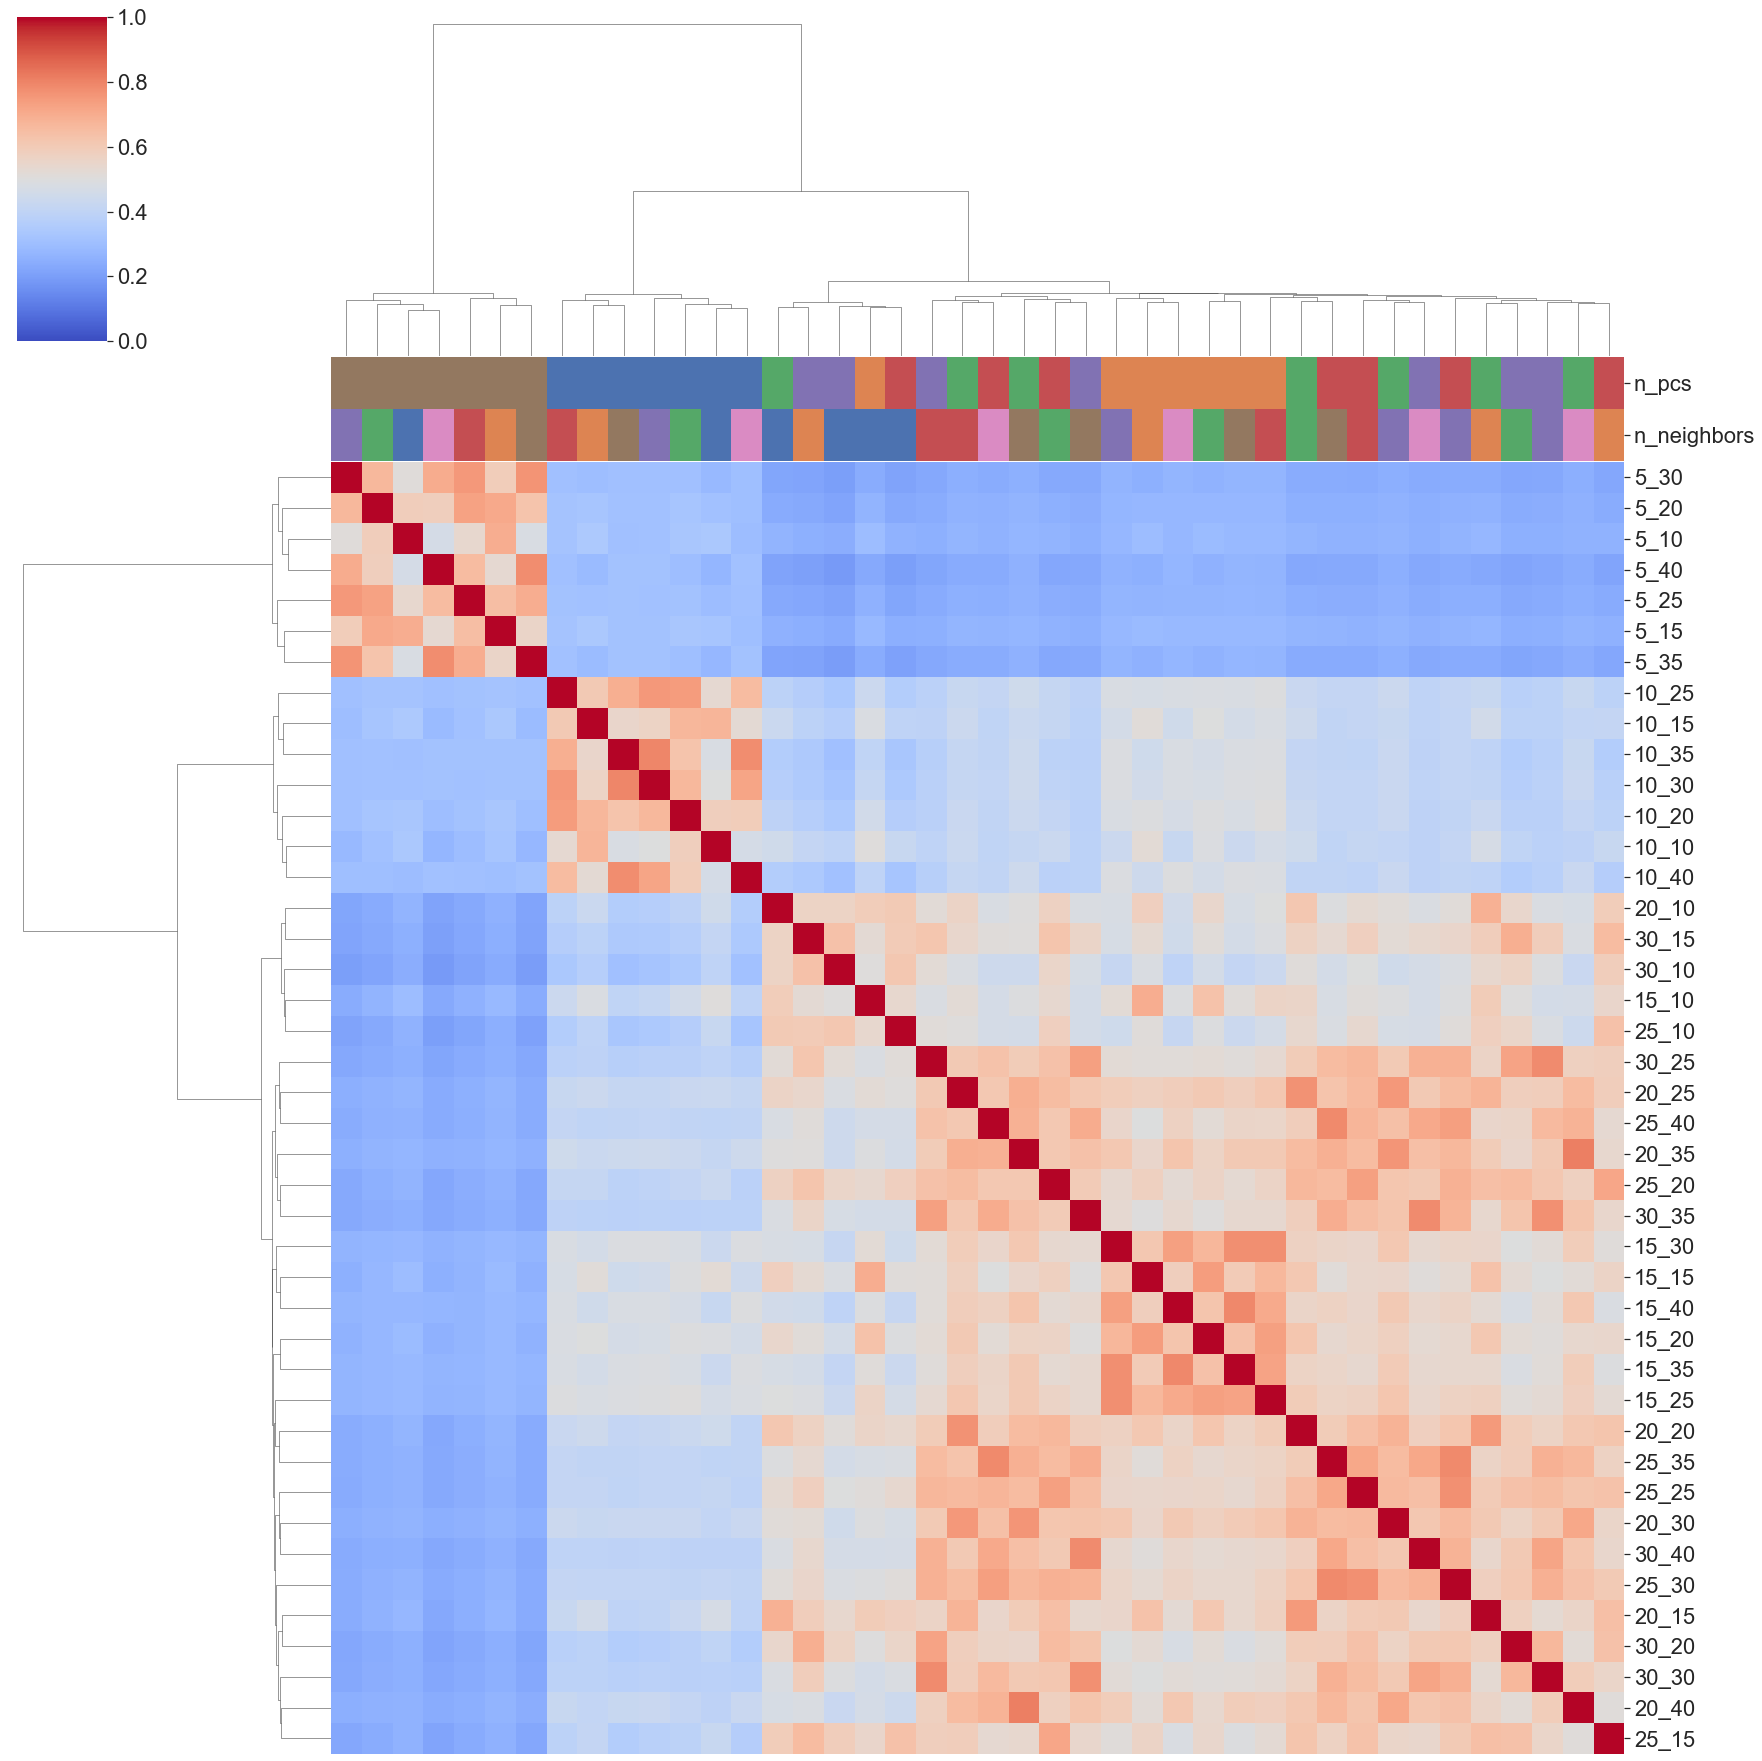

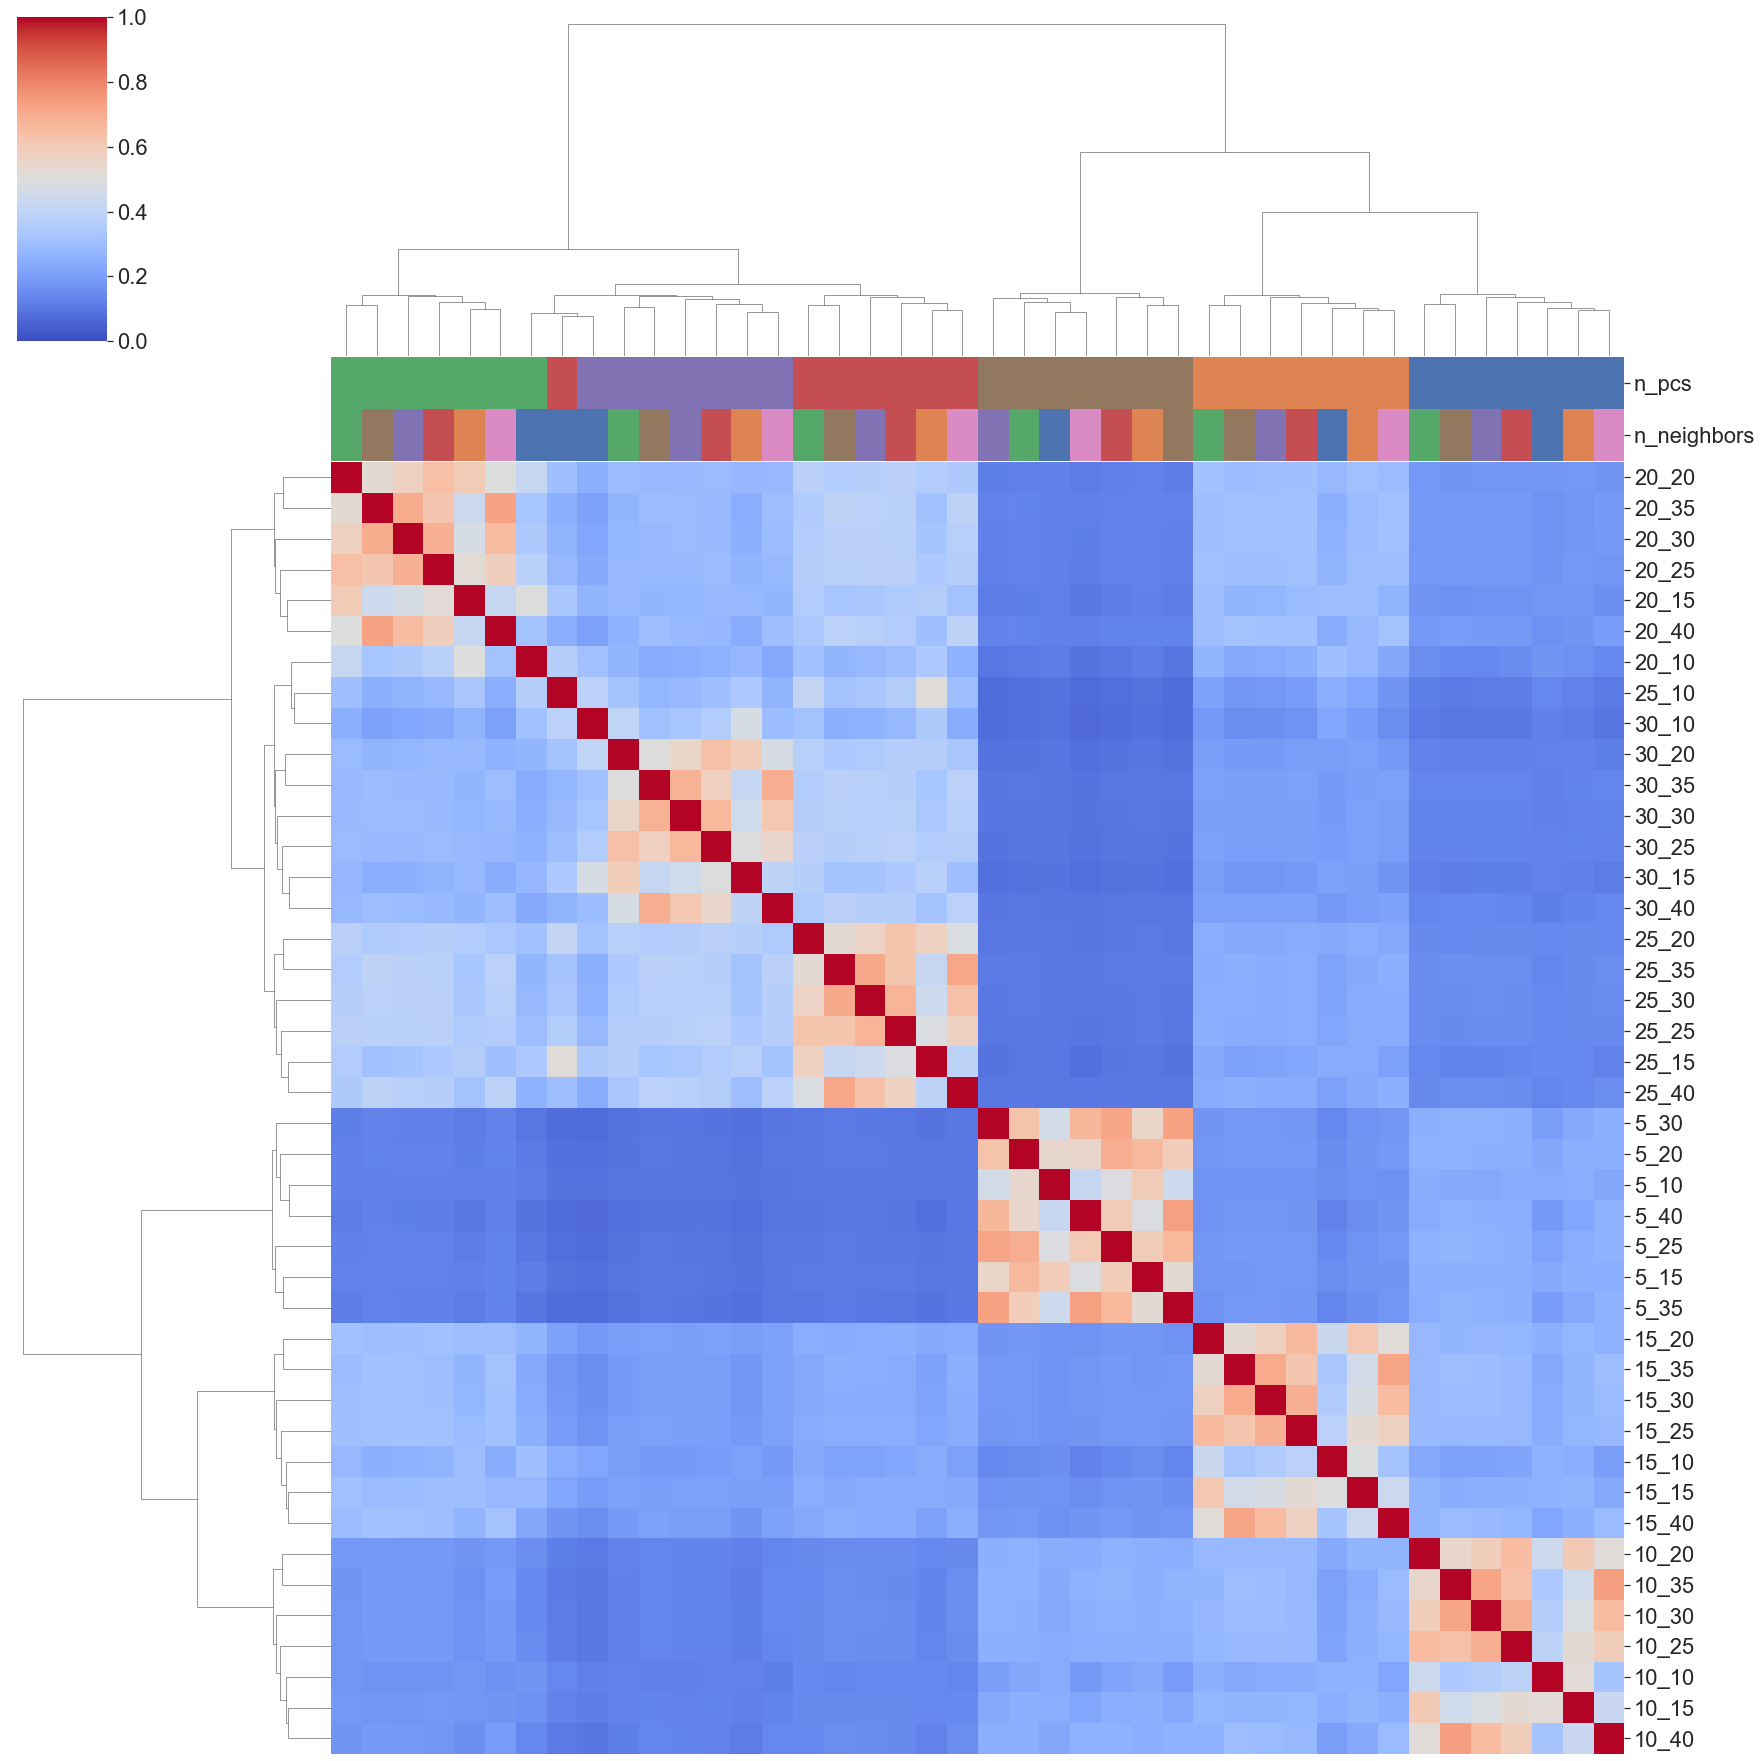

In [89]:
plot_level = 0



#fig = plt.figure(constrained_layout=False, figsize=(15, 20))
#gs = fig.add_gridspec(nrows=3, ncols=2, wspace=0.05)

#ax1 = fig.add_subplot(gs[0, 0])
#ax2 = fig.add_subplot(gs[0, 1])
#ax3 = fig.add_subplot(gs[1, 0])
#ax4 = fig.add_subplot(gs[1, 1])
#ax5 = fig.add_subplot(gs[2, 0])
#ax6 = fig.add_subplot(gs[2, 1])

#axs = [ax1, ax2, ax3, ax4, ax5, ax6]
nd=0
for d in dataset:
    c = [f'{p}_{n}' for p in pc for n in nn]
    s1 = pickle.load(open(f'States/{d}_p5_n10.pkl', 'rb'))
    g = s1.g   
    df = pd.DataFrame( index=range(g.num_vertices()), columns=c)
    for p in pc: 
        for n in nn:
            state = pickle.load(open(f'States/{d}_p{p}_n{n}.pkl', 'rb'))
            g = state.g
            df[f'{p}_{n}'] = np.array(state.project_partition(plot_level, 0).a)

    c = df.columns
    dm = []
    for x in range(len(c) - 1):
        for y in range(x + 1, len(c)):
            dm.append(sklearn.metrics.adjusted_rand_score(df.values[:, x], df.values[:, y]))

    dmf = pd.DataFrame(scipy.spatial.distance.squareform(dm), index=df.columns, columns=df.columns)


    annot = pd.DataFrame([x.split('_') for x in c], columns=['n_pcs', 'n_neighbors'], index=c)

    for c in annot.columns:
        annot[c] = pd.Categorical(annot[c])

    annot['n_pcs'].cat.rename_categories(['C0', 'C1', 'C2', 'C3', 'C4', 'C5'], inplace=True)
    annot['n_neighbors'].cat.rename_categories(['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6'], inplace=True)


#    ii = [x for x in dmf.index if x.endswith(f'_{plot_level}')]

    sdmf = dmf.copy()
    cl = scipy.cluster.hierarchy.ward(sdmf)
    for x in sdmf.index:
        sdmf.loc[x, x] = 1
#    de = scipy.cluster.hierarchy.dendrogram(cl, no_plot=True)
#    M = sdmf.iloc[de['leaves']].iloc[:, de['leaves']]
#    sns.heatmap(M, cbar=False, yticklabels=M.index, xticklabels=[])
    sns.set(font_scale=2)
    sns.clustermap(sdmf, xticklabels=[], col_colors=annot,
              yticklabels=sdmf.index,col_linkage=cl, 
               row_linkage=cl, vmin=0, vmax=1, figsize=(25, 25),
              cmap="coolwarm")#,row_cluster=False,col_cluster=False)
    savefig(f"ClusterMap_L{plot_level}_Panel{nd}.pdf", dpi=300)
    nd += 1

In [90]:
dataset

['10XV3_075',
 'iCELL8_075',
 'Quartzseq_075',
 'MARSseq_075',
 'Crypt_C05',
 'Planaria_schist']